# NeuroNotify: Realistic Multi-Persona Contextual MDP

**IEEE Conference Paper - Experimental Notebook 2**

This experiment addresses the scientific flaws in the initial trial. We move from a single-persona "context" to a true multi-persona environment using **One-Hot Encoding (OHE)** for categorical user separation and **Double DQN (DDQN)** for training stability.

## Key Rigor Improvements:
1. **Categorical Encoding**: Users are represented as distinct dimensions, not a float spectrum.
2. **Mixed Training**: The agent is exposed to different personas randomly across episodes.
3. **Harsher Penalties**: Tripled the interruption cost (-3.0) to force strategic timing.
4. **Stability Protocol**: Implementation of DDQN to mitigate overestimation bias.

## 1. Setup and Imports

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import random

# Add src to path
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

# Import our refactored modules
from src.env import NotificationEnv, UserProfile, STUDENT_PROFILE, WORKER_PROFILE, WORKAHOLIC_PROFILE
from src.networks import QNetwork, get_device
from src.agents import DQNAgent
from src.utils import (
    plot_learning_curve,
    plot_behavioral_heatmap,
    plot_dual_heatmap,
    MetricsLogger,
    compute_moving_average
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = get_device()
print(f"🖥️  Using device: {device}")

🖥️  Using device: mps


## 2. Multi-Persona Definition

We use three distinct personas to challenge the agent's contextual mapping:

1. **Student (ID: 0)**: Night owl, high responsiveness.
2. **Worker (ID: 1)**: 9-5 schedule, work penalty at day.
3. **Workaholic (ID: 2)**: Long hours (8am-8pm), extreme punishment for interruption.

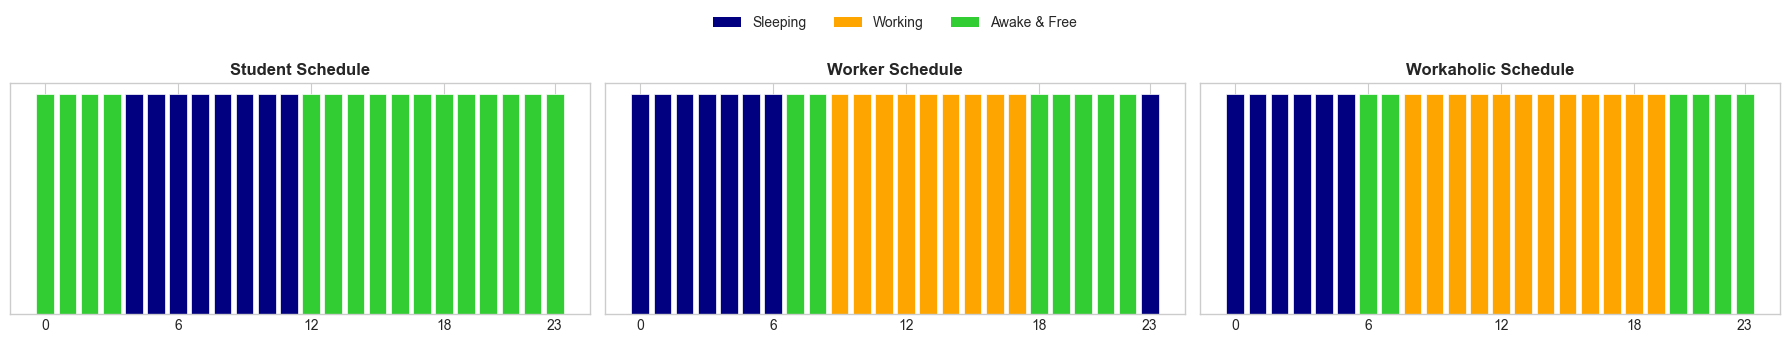

In [2]:
profiles = [STUDENT_PROFILE, WORKER_PROFILE, WORKAHOLIC_PROFILE]
profile_names = ["Student", "Worker", "Workaholic"]

# Visualize schedules
fig, axes = plt.subplots(1, 3, figsize=(18, 3))
from matplotlib.patches import Patch

for i, (profile, name) in enumerate(zip(profiles, profile_names)):
    ax = axes[i]
    hours = np.arange(24)
    colors = []
    for h in hours:
        if not profile.is_awake(h): colors.append('navy')
        elif profile.is_working(h): colors.append('orange')
        else: colors.append('limegreen')
    
    ax.bar(hours, [1]*24, color=colors, edgecolor='white', linewidth=0.5)
    ax.set_title(f"{name} Schedule", fontweight='bold')
    ax.set_xticks([0, 6, 12, 18, 23])
    ax.set_yticks([])

legend_elements = [
    Patch(facecolor='navy', label='Sleeping'),
    Patch(facecolor='orange', label='Working'),
    Patch(facecolor='limegreen', label='Awake & Free')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
plt.show()

## 3. Training: Contextual Mixed-Mode

We train for 3,000 episodes to ensure the agent converges on all three contexts. The environment now uses dynamic one-hot encoding.

In [3]:
# Config
NUM_EPISODES = 3000
NUM_PERSONAS = 3
STATE_DIM = 4 + NUM_PERSONAS # [hour, day, recency, annoyance, OHEx3]
ACTION_DIM = 2

# Hyperparams
agent = DQNAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    learning_rate=0.0005, # Slightly lower for stability
    gamma=0.99,
    epsilon_decay=0.999, # Slower exploration decay for multi-context
    use_double_dqn=True,
    device=device
)

# Metric loggers per persona
global_metrics = MetricsLogger()
persona_rewards = {name: [] for name in profile_names}

print(f"🚀 Initializing Contextual DDQN on {device}...")
print(f"State Dimension: {STATE_DIM} (Includes 3-persona OHE)")

🚀 Initializing Contextual DDQN on mps...
State Dimension: 7 (Includes 3-persona OHE)


In [4]:
for episode in tqdm(range(NUM_EPISODES), desc="Contextual Training"):
    # Randomly select a persona for this episode
    persona_idx = random.randint(0, NUM_PERSONAS - 1)
    current_profile = profiles[persona_idx]
    
    # Init Env with the selected profile
    env = NotificationEnv(user_profile=current_profile, num_users=NUM_PERSONAS)
    state, _ = env.reset()
    
    ep_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        agent.store_transition(state, action, reward, next_state, done)
        loss = agent.train_step()
        
        state = next_state
        ep_reward += reward
        
    # Global sync
    agent.decay_epsilon()
    if (episode + 1) % 10 == 0: agent.update_target()
    
    # Logging
    global_metrics.log_episode(reward=ep_reward, length=168, clicks=0, sends=0)
    persona_rewards[profile_names[persona_idx]].append(ep_reward)
    
    # Fallback logging if widgets fail
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{NUM_EPISODES} | Avg Reward: {np.mean(global_metrics.episode_rewards[-10:]):.2f} | Epsilon: {agent.epsilon:.3f}")

print("✅ Mixed-Persona Training Complete")

Contextual Training:   3%|▎         | 102/3000 [00:07<04:47, 10.07it/s]

Episode 100/3000 | Avg Reward: -25.80 | Epsilon: 0.905


Contextual Training:   7%|▋         | 202/3000 [00:16<03:27, 13.47it/s]

Episode 200/3000 | Avg Reward: -21.80 | Epsilon: 0.819


Contextual Training:  10%|█         | 303/3000 [00:27<04:05, 10.98it/s]

Episode 300/3000 | Avg Reward: -24.30 | Epsilon: 0.741


Contextual Training:  13%|█▎        | 402/3000 [00:38<04:10, 10.38it/s]

Episode 400/3000 | Avg Reward: -26.10 | Epsilon: 0.670


Contextual Training:  17%|█▋        | 500/3000 [00:56<13:43,  3.04it/s]

Episode 500/3000 | Avg Reward: -27.10 | Epsilon: 0.606


Contextual Training:  20%|██        | 600/3000 [01:19<09:05,  4.40it/s]

Episode 600/3000 | Avg Reward: -27.70 | Epsilon: 0.549


Contextual Training:  23%|██▎       | 701/3000 [01:45<06:22,  6.01it/s]

Episode 700/3000 | Avg Reward: -28.30 | Epsilon: 0.496


Contextual Training:  27%|██▋       | 800/3000 [02:16<09:13,  3.98it/s]

Episode 800/3000 | Avg Reward: -21.60 | Epsilon: 0.449


Contextual Training:  30%|███       | 900/3000 [02:53<19:53,  1.76it/s]

Episode 900/3000 | Avg Reward: -31.00 | Epsilon: 0.406


Contextual Training:  33%|███▎      | 1000/3000 [03:35<08:51,  3.76it/s]

Episode 1000/3000 | Avg Reward: -24.40 | Epsilon: 0.368


Contextual Training:  37%|███▋      | 1101/3000 [04:16<14:25,  2.19it/s]

Episode 1100/3000 | Avg Reward: -11.80 | Epsilon: 0.333


Contextual Training:  40%|████      | 1200/3000 [05:04<16:17,  1.84it/s]

Episode 1200/3000 | Avg Reward: 3.30 | Epsilon: 0.301


Contextual Training:  43%|████▎     | 1300/3000 [05:59<16:47,  1.69it/s]

Episode 1300/3000 | Avg Reward: -4.80 | Epsilon: 0.272


Contextual Training:  47%|████▋     | 1401/3000 [07:01<14:36,  1.82it/s]

Episode 1400/3000 | Avg Reward: 2.30 | Epsilon: 0.246


Contextual Training:  50%|█████     | 1500/3000 [07:55<14:34,  1.72it/s]

Episode 1500/3000 | Avg Reward: -5.90 | Epsilon: 0.223


Contextual Training:  53%|█████▎    | 1600/3000 [09:05<13:33,  1.72it/s]

Episode 1600/3000 | Avg Reward: -23.10 | Epsilon: 0.202


Contextual Training:  57%|█████▋    | 1700/3000 [10:16<14:08,  1.53it/s]

Episode 1700/3000 | Avg Reward: 4.90 | Epsilon: 0.183


Contextual Training:  60%|██████    | 1800/3000 [11:25<14:24,  1.39it/s]

Episode 1800/3000 | Avg Reward: 8.70 | Epsilon: 0.165


Contextual Training:  63%|██████▎   | 1900/3000 [12:27<12:26,  1.47it/s]

Episode 1900/3000 | Avg Reward: 4.20 | Epsilon: 0.149


Contextual Training:  67%|██████▋   | 2000/3000 [13:39<15:02,  1.11it/s]

Episode 2000/3000 | Avg Reward: 19.30 | Epsilon: 0.135


Contextual Training:  70%|███████   | 2100/3000 [14:51<11:03,  1.36it/s]

Episode 2100/3000 | Avg Reward: 18.00 | Epsilon: 0.122


Contextual Training:  73%|███████▎  | 2200/3000 [16:03<10:26,  1.28it/s]

Episode 2200/3000 | Avg Reward: 26.20 | Epsilon: 0.111


Contextual Training:  77%|███████▋  | 2300/3000 [17:19<09:37,  1.21it/s]

Episode 2300/3000 | Avg Reward: 37.20 | Epsilon: 0.100


Contextual Training:  80%|████████  | 2400/3000 [18:35<07:58,  1.26it/s]

Episode 2400/3000 | Avg Reward: 36.10 | Epsilon: 0.091


Contextual Training:  83%|████████▎ | 2500/3000 [19:50<07:31,  1.11it/s]

Episode 2500/3000 | Avg Reward: 19.10 | Epsilon: 0.082


Contextual Training:  87%|████████▋ | 2600/3000 [21:04<05:07,  1.30it/s]

Episode 2600/3000 | Avg Reward: 24.10 | Epsilon: 0.074


Contextual Training:  90%|█████████ | 2700/3000 [22:19<03:18,  1.51it/s]

Episode 2700/3000 | Avg Reward: 35.30 | Epsilon: 0.067


Contextual Training:  93%|█████████▎| 2800/3000 [23:35<02:28,  1.34it/s]

Episode 2800/3000 | Avg Reward: 27.90 | Epsilon: 0.061


Contextual Training:  97%|█████████▋| 2900/3000 [24:48<01:15,  1.32it/s]

Episode 2900/3000 | Avg Reward: 25.60 | Epsilon: 0.055


Contextual Training: 100%|██████████| 3000/3000 [26:01<00:00,  1.92it/s]

Episode 3000/3000 | Avg Reward: 59.20 | Epsilon: 0.050
✅ Mixed-Persona Training Complete


## 4. Stability Analysis

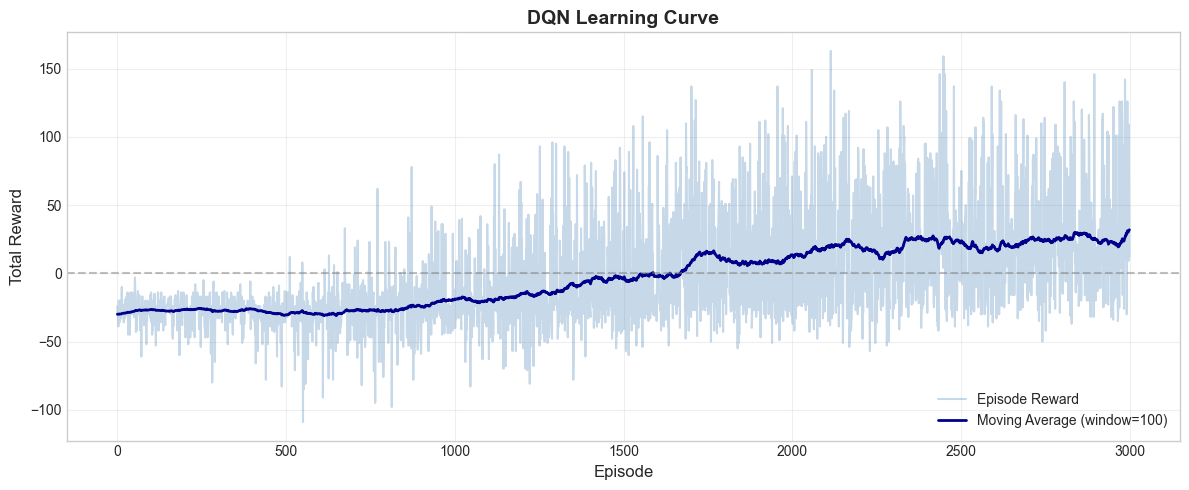

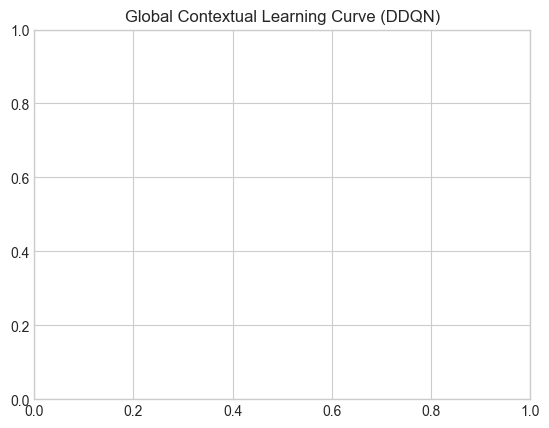

In [13]:
plot_learning_curve(global_metrics.episode_rewards, window_size=100)
plt.title("Global Contextual Learning Curve (DDQN)")
plt.show()

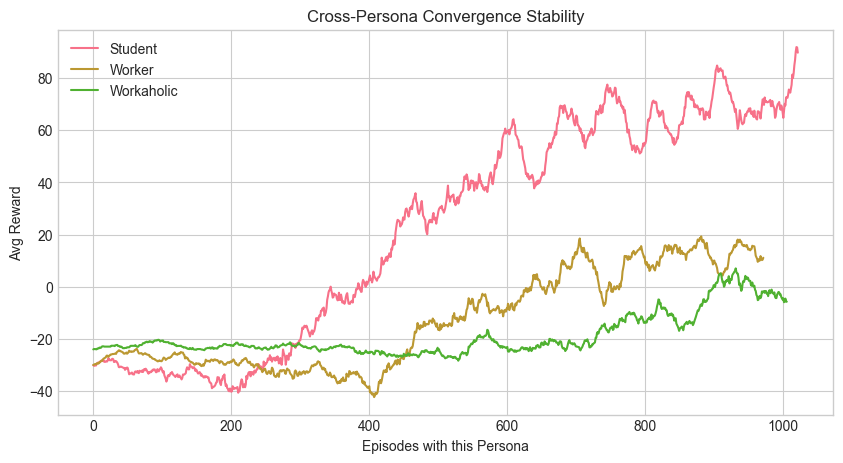

In [6]:
# Persona-specific convergence
plt.figure(figsize=(10, 5))
for name in profile_names:
    rewards = persona_rewards[name]
    if len(rewards) > 10:
        plt.plot(compute_moving_average(rewards, 30), label=name)
plt.legend()
plt.title("Cross-Persona Convergence Stability")
plt.xlabel("Episodes with this Persona")
plt.ylabel("Avg Reward")
plt.show()

## 5. Multi-Persona Behavioral Evaluation

We evaluate the frozen policy for each persona separately to see if the agent truly learned different schedules.

In [7]:
def evaluate_persona(profile, num_users=3):
    env = NotificationEnv(user_profile=profile, num_users=num_users)
    state, _ = env.reset()
    rewards = 0
    # Standard 1-week eval
    for _ in range(168):
        action = agent.act(state, epsilon=0.0)
        state, reward, term, trunc, _ = env.step(action)
        rewards += reward
        if term or trunc: break
    return rewards

print("--- Final Policy Evaluation ---")
for profile, name in zip(profiles, profile_names):
    score = evaluate_persona(profile)
    print(f"{name:12}: Evaluation Reward = {score:.2f}")

--- Final Policy Evaluation ---
Student     : Evaluation Reward = 89.00
Worker      : Evaluation Reward = 5.00
Workaholic  : Evaluation Reward = 18.00


Saved heatmap to exp2_heatmaps_all_personas.png
Heatmap generated and saved to exp2_heatmaps_all_personas.png


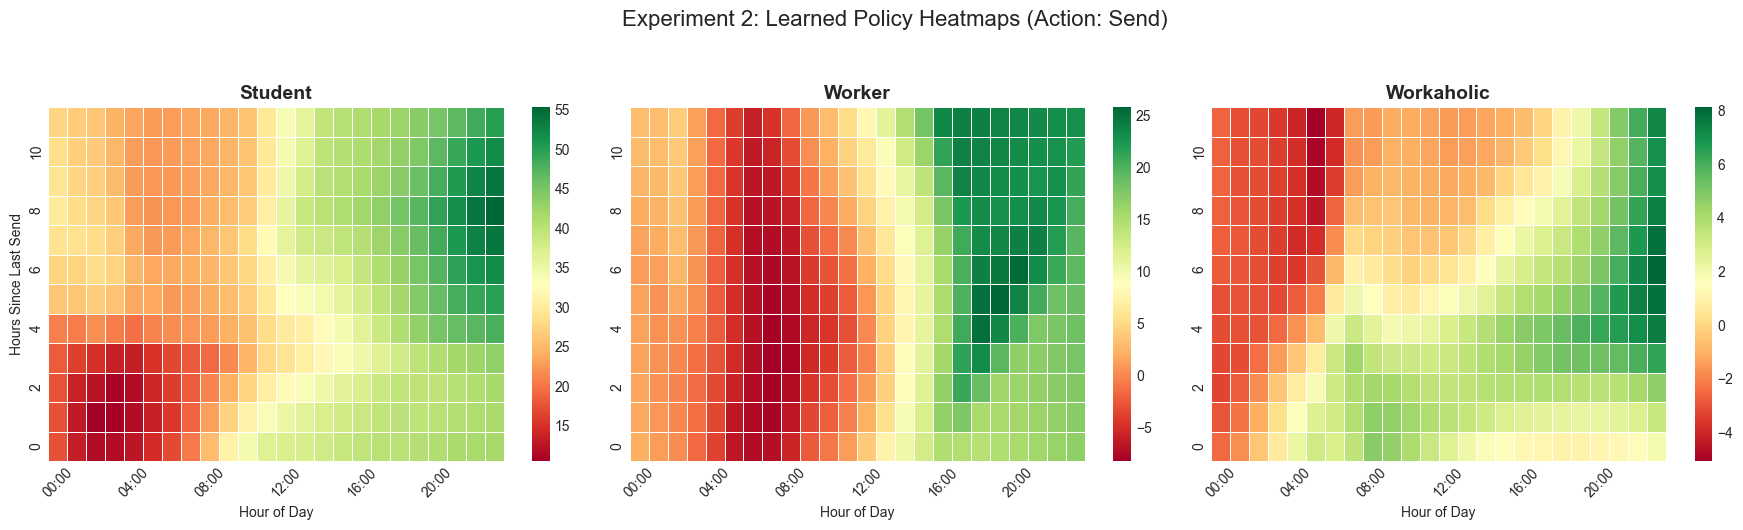

In [8]:
# Use the new plotting function from src.plotting
from src.plotting import plot_exp2_heatmaps

# Generate and save the requested plot: exp2_heatmaps_all_personas.png
plot_exp2_heatmaps(agent, profiles, profile_names, save_path='exp2_heatmaps_all_personas.png')
print("Heatmap generated and saved to exp2_heatmaps_all_personas.png")


In [9]:
# Save the advanced model
agent.save("models/contextual_ddqn.pth")
print("💾 Model saved to models/contextual_ddqn.pth")

💾 Model saved to models/contextual_ddqn.pth
